# **Assignment No. 2**

## Name: CANOY RAYMART JAY
## Student ID #: 2020021376
## Link to the Google Colab file:
https://colab.research.google.com/drive/1vh-p75XQcx3FRx5gRcO9AAK6MWAAbtU3?authuser=3#scrollTo=xAh5UY25ykXH
---

## **(00) Setting up**

### **(00.1)** Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **(00.2)** Prerequisites

In [ ]:
# Python >= 3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn >= 0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow >= 2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import os
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import pickle as pkl

# To make this notebook's output stable across runs
np.random.seed(42)

# Plotting figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### **(00.3) Functions**

In [ ]:
# Saving figures
PROJECT_ROOT_DIR = '/content/drive/Shareddrives/[AY2021Semester1] BRI507 (Introduction to Machine Learning)/Assignment#2'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images')
if not os.path.exists(IMAGES_PATH):
  os.makedirs(IMAGES_PATH)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
  print("Saving figure", fig_id)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

def save_npy(filename, array):
  filepath = os.path.join(PROJECT_ROOT_DIR, filename)
  with open(filepath, 'wb') as f:
    np.save(f, array)

def open_npy(filename):
  filepath = os.path.join(PROJECT_ROOT_DIR, filename)
  with open(filepath, 'rb') as f:
    np.load(f)

## **(01) Loading the dataset**

In [ ]:
data_path = os.path.join(PROJECT_ROOT_DIR, 'trn_dat.npy')
label_path = os.path.join(PROJECT_ROOT_DIR, 'trn_lbl.npy')

data_ = np.load(data_path)
label_ = np.load(label_path)

In [ ]:
print('\n --Shape of the training dataset-- \n')
data_shape = data_.shape
print(data_shape)

print('\n --Shape of the label of the training dataset-- \n')
label_shape = label_.shape
print(label_shape)


 --Shape of the training dataset-- 

(2800, 32, 32, 16)

 --Shape of the label of the training dataset-- 

(2800,)


## **(02) Analyzing the dataset**


In [ ]:
m, height, width, slices = data_.shape

print('\n --Information about the training dataset-- \n')
print(
"""
m       =   {},
height  =   {},
width   =   {},
slices  =   {},
""".format(m, height, width, slices)
)


 --Information about the training dataset-- 


m       =   2800,
height  =   32,
width   =   32,
slices  =   16,



In [ ]:
true_index = np.where(label_ == True)
false_index = np.where(label_ == False)

data_summary = pd.DataFrame({
    "Index for 'True'": [i for i in np.array(true_index).T],
    "Index for False": [i for i in np.array(false_index).T]
})

data_summary

,Index for 'True',Index for False
0,[1400],[0]
1,[1401],[1]
2,[1402],[2]
3,[1403],[3]
4,[1404],[4]
...,...,...
1395,[2795],[1395]
1396,[2796],[1396]
1397,[2797],[1397]
1398,[2798],[1398]


* In the training dataset,
  * the first 1400 data contains the 1400 benign patches, while
  * the remaining 1400 data contains the 1400 malignant patches

### **(02.1) Making training and test sets**

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=5, test_size=0.05, random_state=42)

for train_index, test_index in strat_split.split(data_, label_):
  data_train, data_test = data_[train_index], data_[test_index]
  label_train, label_test = label_[train_index], label_[test_index]
  save_npy('data_train.npy', data_train)
  save_npy('data_test.npy', data_test)
  save_npy('label_train.npy', label_train)
  save_npy('label_test.npy', label_test)

In [ ]:
for i in [False, True]:
  if i == True:
    print('\n --Benign patches-- \n')
  else:
    print('\n --Malignant patches-- \n')
  print('Training:', label_train[label_train == i].shape, 'Test', label_test[label_test == i].shape)


 --Malignant patches-- 

Training: (1330,) Test (70,)

 --Benign patches-- 

Training: (1330,) Test (70,)


Saving figure Training_data


<function matplotlib.pyplot.show>

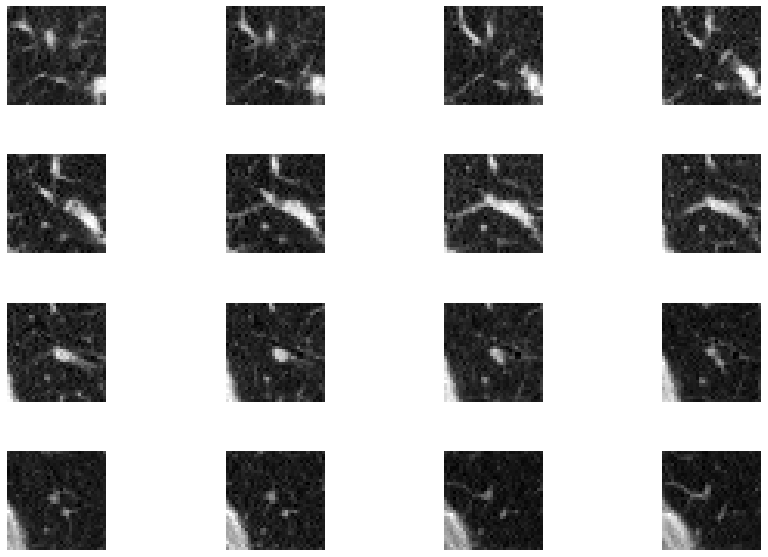

In [ ]:
plt.figure(figsize=(15, 10))
plt.title('Label is {}'.format(label_train[3]), fontsize=16, loc='center')
for i in range(data_train.shape[3]):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(data_train[3,:,:,i], cmap="gray")
  plt.axis(False)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('Training_data', tight_layout=False)
plt.show

## **(03) Preprocessing the dataset**


### **(03.1) Normalizing the dataset**

In [ ]:
print('\n --Minimum value in the dataset-- \n')
print(np.min(data_train))

print('\n --Maximum value in the dataset-- \n')
print(np.max(data_train))


 --Minimum value in the dataset-- 

-1543.0

 --Maximum value in the dataset-- 

5230.0


* In CT scans, the raw voxel intensity is stored in Hounsfield units.

* In this dataset, the range of values is $[-1543.0, 5230.0]$

* To normalize CT scans, a threshold between -1000 to 400 is commonly used.

  * Above 400 are bones with different radiointensity; hence, this is used as the upper bound.

In [ ]:
def normalization(volume):
  min = -1000
  max = 400
  volume[volume < min] = min
  volume[volume > max] = max
  volume = (volume - min)/(max - min)
  volume = volume.astype("float32")
  return volume

### **(03.2) Transformation Pipeline**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

norm_transformer = FunctionTransformer(normalization)

preparation_pipeline = Pipeline([
                         ('normalization', norm_transformer),
])

In [ ]:
data_train_prepared = preparation_pipeline.fit_transform(data_train)

Saving figure Normalized_training_data


<function matplotlib.pyplot.show>

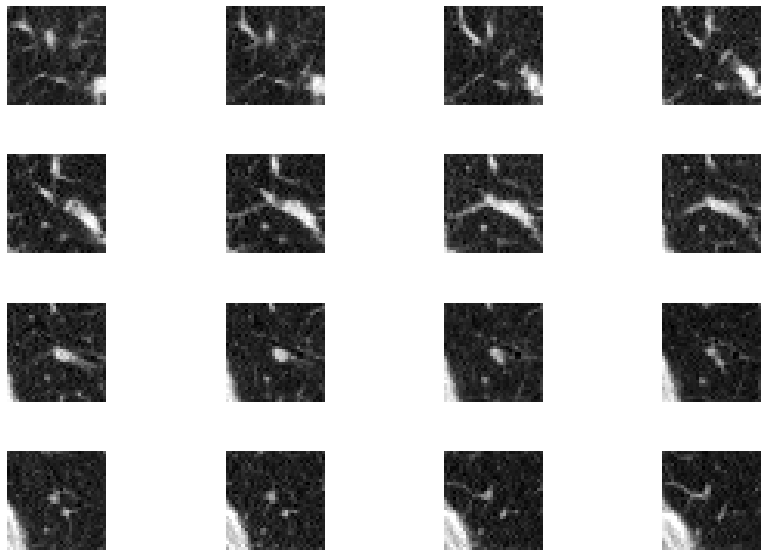

In [ ]:
plt.figure(figsize=(15, 10))
for i in range(data_train_prepared.shape[3]):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(data_train_prepared[3,:,:,i], cmap="gray")
  plt.axis(False)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('Normalized_training_data', tight_layout=False)
plt.show

## **(04) Building train and validation datasets**

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split_val = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=42)

for train_index, val_index in strat_split_val.split(data_train_prepared, label_train):
  data_train_prepared_train, data_train_prepared_val = data_train_prepared[train_index], data_train_prepared[val_index]
  label_train_prepared_train, label_train_prepared_val = label_train[train_index], label_train[val_index]
  save_npy('data_train_prepared_train.npy', data_train_prepared_train)
  save_npy('data_train_perpared_val.npy', data_train_prepared_val)
  save_npy('label_train_prepared_train.npy', label_train_prepared_train)
  save_npy('label_train_prepared_val.npy', label_train_prepared_val)

print(
    "Number of samples in train and validattion are {} and {}, respectively".format(data_train_prepared_train.shape[0], data_train_prepared_val.shape[0])
)

Number of samples in train and validattion are 2394 and 266, respectively


## **(05) Data Augmentation**

* This data augmentation technique is patterned from https://keras.io/examples/vision/3D_image_classification/

  * The augmentation is done by rotating at random angles during training.
  * Since the data is stored in a rank-3 tensors of shape 
    \begin{equation}
    (\mathtt{samples}, \mathtt{height}, \mathtt{width}, \mathtt{depth}),
    \end{equation}
    a dimension of size 1 is added at axis 4 to be able to perform 3D convolutions on the data. Therefore, the new shape is
     \begin{equation}
    (\mathtt{samples}, \mathtt{height}, \mathtt{width}, \mathtt{depth}, \mathtt{1}).
    \end{equation}

In [ ]:
import random
from scipy import ndimage

@tf.function
def rotate(volume):
  def scipy_rotate(volume):
    angles = [-175, -170, -160, -150, -140, -130, -120, -110, -100, -90, -80, -70, -60, -45, -30, -10, -5, 5, 10, 30, 45, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 175]
    angle = random.choice(angles)
    volume = ndimage.rotate(volume, angle, reshape=False)
    volume[volume < 0] = 0
    volume[volume > 1] = 1
    return volume

  augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
  return augmented_volume

def add_dim(volume):
  volume = tf.expand_dims(volume, -1)
  return volume

def train_preprocessing(volume, label):
  volume = rotate(volume)
  volume = add_dim(volume)
  return volume, label

def validation_preprocessing(volume, label):
  volume = add_dim(volume)
  return volume, label

def loader(volume, label):
  dataset = tf.data.Dataset.from_tensor_slices((volume, label))
  return dataset

In [ ]:
# Data loaders
train_loader = loader(data_train_prepared_train, label_train_prepared_train)
validation_loader = loader(data_train_prepared_val, label_train_prepared_val)

In [ ]:
print('\n --Training Dataset-- \n')
print(train_loader.element_spec)

print('\n --Validation Dataset-- \n')
print(validation_loader.element_spec)


 --Training Dataset-- 

(TensorSpec(shape=(32, 32, 16), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.bool, name=None))

 --Validation Dataset-- 

(TensorSpec(shape=(32, 32, 16), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.bool, name=None))


In [ ]:
batch_size = 2

train_dataset = (
    train_loader.shuffle(len(data_train_prepared_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(data_train_prepared_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

Dimension of the CT scan is (32, 32, 16, 1)


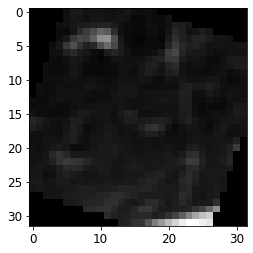

In [ ]:
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is", image.shape)
plt.imshow(np.squeeze(image[:,:,15]), cmap="gray")

## **(06) Building a model**

* This model is patterned from https://keras.io/examples/vision/3D_image_classification/

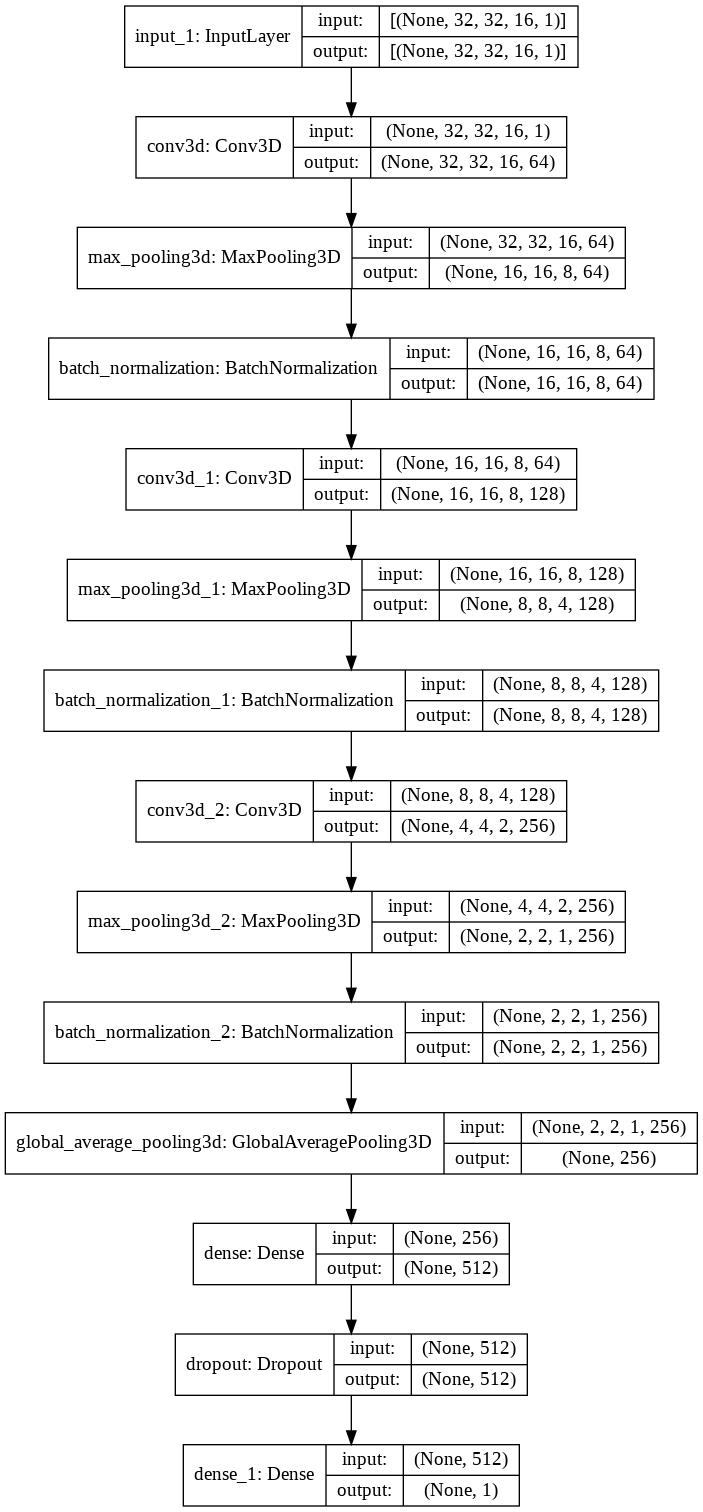

In [ ]:
def model_(height=32, width=32, depth=16):
  
  inputs = keras.Input((width, height, depth, 1))

  x = layers.Conv3D(64, 3, strides=1, padding="same", activation="relu")(inputs)
  x = layers.MaxPool3D(pool_size=2)(x)
  x = layers.BatchNormalization()(x)

  x = layers.Conv3D(128, 3, strides=1, padding="same", activation="relu")(x)
  x = layers.MaxPool3D(pool_size=2)(x)
  x = layers.BatchNormalization()(x)

  x = layers.Conv3D(256, 3, strides=2, padding="same", activation="relu")(x)
  x = layers.MaxPool3D(pool_size=2)(x)
  x = layers.BatchNormalization()(x)

  #x = layers.Conv3D(512, 3, strides=2, padding="same", activation="relu")(x)
  #x = layers.MaxPool3D(pool_size=2)(x)
  #x = layers.BatchNormalization()(x)

  #x = layers.Conv3D(1024, 3, strides=2, padding="same", activation="relu")(x)
  #x = layers.MaxPool3D(pool_size=2)(x)
  #x = layers.BatchNormalization()(x)
  
  x = layers.GlobalAveragePooling3D()(x)
  x = layers.Dense(units = 512, activation="relu")(x)
  x = layers.Dropout(0.5)(x)

  outputs = layers.Dense(units=1, activation="sigmoid")(x)

  model = keras.Model(inputs, outputs, name="3dcnn")
  return model

model = model_(height=32, width=32, depth=16)
keras.utils.plot_model(model, show_shapes=True)
#model.summary()

In [ ]:
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 32, 32, 16, 1)]   0         
_________________________________________________________________
conv3d_48 (Conv3D)           (None, 32, 32, 16, 64)    1792      
_________________________________________________________________
max_pooling3d_43 (MaxPooling (None, 16, 16, 8, 64)     0         
_________________________________________________________________
batch_normalization_46 (Batc (None, 16, 16, 8, 64)     256       
_________________________________________________________________
conv3d_49 (Conv3D)           (None, 16, 16, 8, 128)    221312    
_________________________________________________________________
max_pooling3d_44 (MaxPooling (None, 8, 8, 4, 128)      0         
_________________________________________________________________
batch_normalization_47 (Batc (None, 8, 8, 4, 128)      512   

## **(07) Training the model**

In [ ]:

initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps = 100000, decay_rate=0.96, staircase = True
)

callbacks = [
             keras.callbacks.ModelCheckpoint(os.path.join(PROJECT_ROOT_DIR, "3d_image_classification_{epoch}.h5"), save_best_only=True),
             keras.callbacks.EarlyStopping(patience=15, monitor="accuracy", restore_best_weights=True)
]

model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["accuracy"]
)

epochs = 100
history = model.fit(
    train_dataset, 
    validation_data=validation_dataset, 
    epochs=epochs, 
    callbacks=callbacks,
    shuffle=True,
)

with open(os.path.join(PROJECT_ROOT_DIR,'/trainHistoryDict'), 'wb') as file_pi:
        pkl.dump(history.history, file_pi)

Epoch 1/100
1197/1197 [==============================] - 24s 18ms/step - loss: 0.6903 - accuracy: 0.6003 - val_loss: 0.6771 - val_accuracy: 0.6617
Epoch 2/100
1197/1197 [==============================] - 21s 18ms/step - loss: 0.6395 - accuracy: 0.6479 - val_loss: 0.5313 - val_accuracy: 0.7632
Epoch 3/100
1197/1197 [==============================] - 21s 18ms/step - loss: 0.6186 - accuracy: 0.6658 - val_loss: 0.4889 - val_accuracy: 0.7857
Epoch 4/100
1197/1197 [==============================] - 21s 18ms/step - loss: 0.5863 - accuracy: 0.6846 - val_loss: 0.5029 - val_accuracy: 0.7632
Epoch 5/100
1197/1197 [==============================] - 21s 18ms/step - loss: 0.5645 - accuracy: 0.7097 - val_loss: 0.4165 - val_accuracy: 0.8045
Epoch 6/100
1197/1197 [==============================] - 21s 18ms/step - loss: 0.5475 - accuracy: 0.7251 - val_loss: 0.4129 - val_accuracy: 0.8233
Epoch 7/100
1197/1197 [==============================] - 21s 18ms/step - loss: 0.4831 - accuracy: 0.7602 - val_loss: 0

Saving figure model_learning_curves_plot_Date20210612


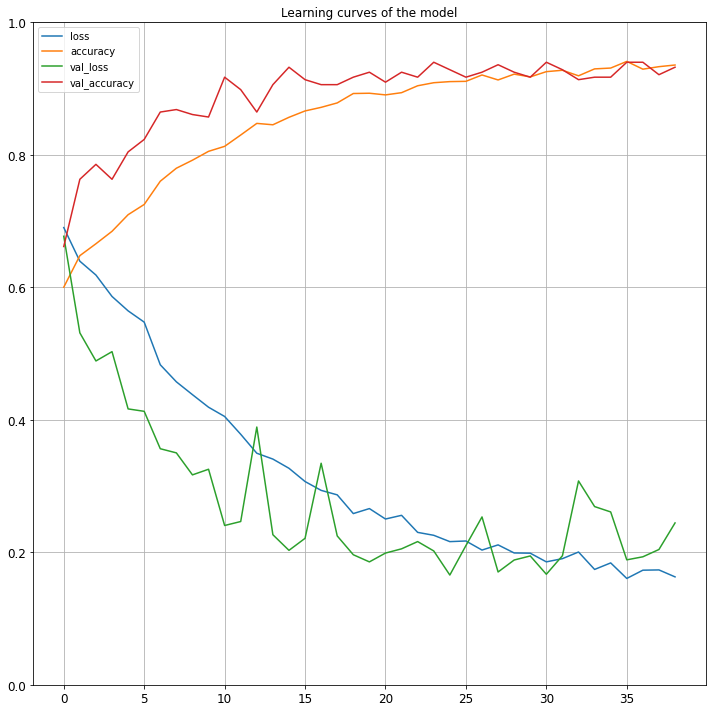

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(10, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1.0)
plt.title('Learning curves of the model', fontsize=12)
save_fig("model_learning_curves_plot_Date20210612")
plt.show()

* At the 25th epoch, the model has achieved a validation accuracy of 

In [ ]:
# Full Pipeline
add_dimension_transform = FunctionTransformer(add_dim)
best_classifier_model = keras.models.load_model(os.path.join(PROJECT_ROOT_DIR, "3d_image_classification_25.h5"))

full_preparation_pipeline = Pipeline([
                                          ("preparation", preparation_pipeline),
                                          ("add_dimension", add_dimension_transform),
])

In [ ]:
dump(full_preparation_pipeline, os.path.join(PROJECT_ROOT_DIR, 'full_pipeline.pkl'))

['/content/drive/Shareddrives/[AY2021Semester1] BRI507 (Introduction to Machine Learning)/Assignment#2/full_pipeline.pkl']

## **(08) Evaluating the test dataset**

In [128]:
test_prepared = full_preparation_pipeline.fit_transform(data_test)

predicted_values = best_classifier_model.predict(test_prepared)

In [129]:
predicted_values_binary = np.zeros(len(predicted_values), dtype=np.uint8)

for i in range(len(predicted_values)):
  if predicted_values[i]*100 >= 50:
    predicted_values_binary[i] = bool(1)
  else:
    predicted_values_binary[i] = bool(0)

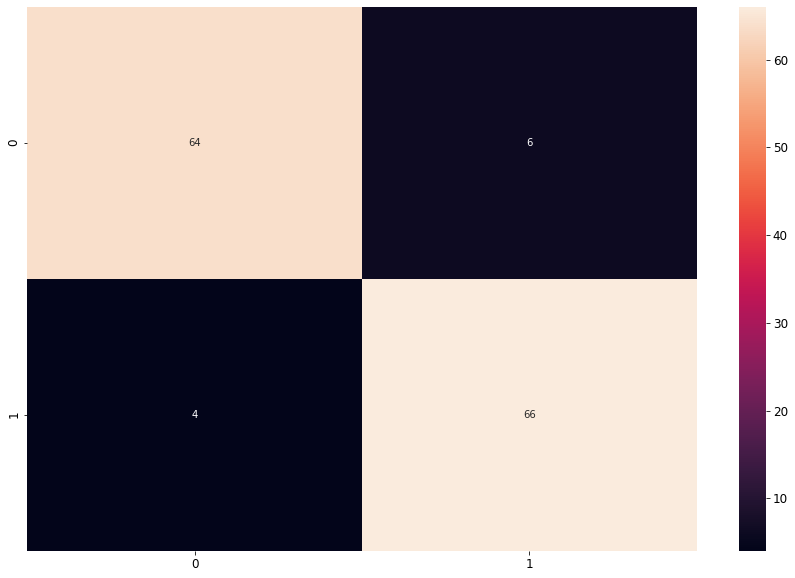

In [130]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(15,10))
cm = confusion_matrix(label_test.astype('uint8'), predicted_values_binary)
sns.heatmap(cm, annot=True, fmt = 'g')

* 6 benign images are wrongly classified as malignant.
* 4 malignant images are wrongly classified as benigh.

In [131]:
print('Accurate:\n',label_test.astype('uint8'), '\nPredicted\n', predicted_values_binary.astype('uint8'))

Accurate:
 [0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 1 1 0 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1 0 0 1 0
 1 1 1 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 1 1
 1 1 0 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1
 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 1 1] 
Predicted
 [0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 1 1 0 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 0
 1 0 1 1 1 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0
 1 1 0 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0
 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0 1 0 1 0 0 1 0 1 1]


In [132]:
from sklearn.metrics import roc_auc_score

print('ROC AUC score:', roc_auc_score(label_test.astype('uint8'), predicted_values_binary))

ROC AUC score: 0.9285714285714286


## **(09) Summary**

* This model has a validation accuracy of 92.86% at the 25th epoch.

* When evaluated on the test dataset it gets an ROC AUC score of 93.86%.